In [1]:
import psycopg2
import psycopg2.extras
import getpass
from IPython.display import display
import ipywidgets
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from astropy.time import Time
from astropy.coordinates import get_moon, GCRS
import astropy.units as u

This notebook searches the COSMOS field for candidates that (on their first night of detection) rose by at least 0.2 mag over at least 4 detections

In [2]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect( f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'" )

db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

DB User:  kennedyt
DB Password:  ············


In [3]:
query = ('SELECT e.mjd FROM exposures e '
         'WHERE q3c_radial_query(e.ra,e.dec,150,2.2,3) '
         'LIMIT 10000000')
cursor.execute( query )

datesquery = cursor.fetchall()

In [4]:
# Make a list of every observing night (rounded to the nearest MJD)
odates = np.unique( np.round( datesquery ) )
odates

array([59292., 59295., 59297., 59301., 59304., 59307., 59310., 59313.,
       59316., 59319., 59322., 59325., 59329., 59331., 59333., 59337.,
       59340., 59343., 59346., 59349., 59352., 59356., 59358., 59361.,
       59364., 59367., 59370., 59373., 59376.])

In [5]:
fr = []
frdates = []
fil = 'i' # filter to look for fast riser behavior in
oldcands = np.array( [] ) # used to check if candidates have been detected before

for i in range(len(odates)):
    # Loop through each observing night
    # Grab all detections within a day of the night in question
    lodate = odates[i] - 1
    hidate = odates[i] + 1
    query = ('SELECT o.candidate_id, o.id, e.mjd, o.mag, o.rb, e.id FROM objects o '
             'JOIN subtractions s ON s.id=o.subtraction_id '
             'JOIN exposures e on s.exposure_id = e.id '
             'WHERE q3c_radial_query(e.ra,e.dec,150,2.2,3) '
             'AND o.rb > 0.4 '
             'AND e.mjd > %s '
             'AND e.mjd < %s '
             'AND e.filter = %s'
             'LIMIT 10000000')
    cursor.execute( query, (lodate, hidate, fil) )
    # Store that nights detections in an array
    tempres = np.array( cursor.fetchall(), dtype=str ).transpose()
    # Cut out duplicate objects
    dupearr = np.array( [tempres[0], tempres[2], tempres[3], tempres[4], tempres[5]] ).transpose()
    dupearr = [ "-".join(j) for j in dupearr ]
    dupearr, ind = np.unique( dupearr, return_index=True )
    
    # Rejoin the array without the duplicates
    uarr = np.array( [ i.split("-") for i in dupearr ] ).transpose()
    res = np.array( [uarr[0], tempres[1][ind], uarr[1], uarr[2], uarr[3], uarr[4]] )
    
    # Create an array of each unique candidate detected that night
    ucands, uind, ucounts = np.unique( res[0], return_counts=True, return_index=True )
    
    # Isolate those with at least 4 detections
    goodcands = ucands[ ucounts > 3 ]

    
    # Make an array of detections for each of those candidates, store all of those arrays in "arr"
    arr = np.ones( len( goodcands ), dtype=object )
    for j in range( len( goodcands ) ):
        arr[j] = res[:,res[0,:] == goodcands[j]]
    # Mask out those that 
    # A) have been detected in previous nights, 
    # B) don't rise in every subsequent detection, or 
    # C) don't change by at least 0.2 mag
    good = np.ones( len( arr ), dtype=bool )
    for j in range( len( arr ) ):
        # A)
        if arr[j][0][0] in oldcands:
            good[j] = False
        for k in range( len( arr[j][3] ) - 1 ):
            # B)
            if arr[j][3][k] < arr[j][3][k + 1]:
                good[j] = False
            # C)
            if np.max( arr[j][3].astype(float) ) - np.min( arr[j][3].astype(float) ) < 0.2:
                good[j] = False
            
    # Apply those cuts and append the candidates that passed to fr and frdates
    for j in range( len( arr[good] ) ):
        fr.append( arr[good][j][0][0] )
        frdates.append( [lodate, hidate] )
    # Make a note of all candidates detected this night (for cutting out things that have been previously detected)
    oldcands = np.append( oldcands, ucands )

/usr/common/software/python/3.7-anaconda-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [6]:
len(fr)

1

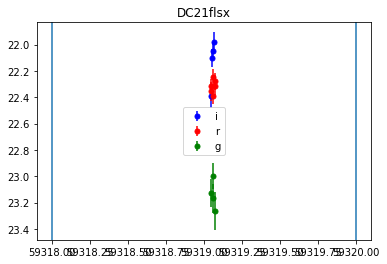

In [9]:
### Plotting up each of the identified fast risers
for i in range( len( fr ) ):
    query = ('SELECT c.id, e.mjd, o.mag, o.magerr, e.filter FROM objects o '
             'JOIN candidates c ON c.id=o.candidate_id '
             'JOIN subtractions s ON s.id=o.subtraction_id '
             'JOIN exposures e ON e.id=s.exposure_id '
             'WHERE c.id=%s '
             'AND o.rb > 0.4')
    cursor.execute( query, ( fr[i], ) )
    array = np.array( cursor.fetchall() ).transpose()
    rmsk = array[4] == 'r'
    gmsk = array[4] == 'g'
    imsk = array[4] == 'i'
    plt.errorbar( ( array[1][imsk] ).astype(float), 
                 ( array[2][imsk] ).astype(float), 
                 yerr=array[3][imsk].astype(float), 
                 fmt='o', 
                 markersize=5, 
                 ls= '', 
                 color='blue', 
                 label='i' )
    plt.errorbar( ( array[1][rmsk] ).astype(float), 
                 ( array[2][rmsk] ).astype(float), 
                 yerr=array[3][rmsk].astype(float), 
                 fmt='o', 
                 markersize=5, 
                 ls= '', 
                 color='r', 
                 label='r' )
    plt.errorbar( ( array[1][gmsk] ).astype(float), 
                 ( array[2][gmsk] ).astype(float), 
                 yerr=array[3][gmsk].astype(float), 
                 fmt='o', 
                 markersize=5, 
                 ls= '', 
                 color='g', 
                 label='g' )
    plt.axvline( float( frdates[i][0] ) )
    plt.axvline( float( frdates[i][1] ) )
    plt.title( array[0][0] )
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()